# 3. Détection de Mots-Clés Stéréotypés

Ce notebook détecte et analyse les **mots-clés stéréotypés** dans les scripts de films :

1. **Détection automatique** : Identifier les phrases contenant des stéréotypes
2. **Extraction de contexte** : Voir les phrases complètes autour des mots-clés
3. **Classification** : Sexisme, racisme, homophobie
4. **Scoring** : Mesurer l'intensité des stéréotypes par film
5. **Exemples concrets** : Afficher les pires cas par décennie

**Objectif** : Identifier les patterns linguistiques problématiques et leur évolution.

In [1]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter, defaultdict

# Nos modules
from dictionaries import (
    GENDER_WORDS, GENDER_STEREOTYPES, GENDERED_ROLES,
    ETHNICITY_WORDS, RACIAL_STEREOTYPES,
    LGBTQ_WORDS, HOMOPHOBIC_CONTEXT,
    ACTION_VERBS, ADJECTIVES
)
from stats_analysis import calculate_relative_frequency

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Imports réussis")

✅ Imports réussis


## 1. Chargement des Données

In [2]:
# Charger les données nettoyées
data_path = Path('../data/processed/scripts_clean.pkl')

if not data_path.exists():
    raise FileNotFoundError(
        "Fichier scripts_clean.pkl introuvable. "
        "Veuillez d'abord exécuter le notebook 0_clean_data.ipynb"
    )

df = pd.read_pickle(data_path)
print(f"✅ {len(df)} scripts chargés")
print(f"   Période : {df['release_year'].min():.0f} - {df['release_year'].max():.0f}")
print(f"   Décennies : {sorted(df['decade'].unique())}")

✅ 1787 scripts chargés
   Période : 1960 - 2020
   Décennies : [np.int64(1960), np.int64(1970), np.int64(1980), np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2020)]


## 2. Fonction de Détection de Contexte

Extraire les phrases contenant les mots-clés stéréotypés

In [3]:
def extract_keyword_contexts(text, keywords, context_window=100):
    """
    Extrait les contextes (phrases) autour des mots-clés.
    
    Args:
        text: Texte du script
        keywords: Liste de mots-clés à chercher
        context_window: Nombre de caractères avant/après
    
    Returns:
        Liste de dictionnaires avec keyword, context, position
    """
    if not isinstance(text, str):
        return []
    
    text_lower = text.lower()
    contexts = []
    
    for keyword in keywords:
        keyword_lower = keyword.lower()
        
        # Trouver toutes les occurrences
        pattern = r'\b' + re.escape(keyword_lower) + r'\b'
        matches = re.finditer(pattern, text_lower)
        
        for match in matches:
            start = match.start()
            end = match.end()
            
            # Extraire le contexte
            context_start = max(0, start - context_window)
            context_end = min(len(text), end + context_window)
            
            context = text[context_start:context_end]
            
            # Nettoyer (enlever retours à la ligne multiples)
            context = ' '.join(context.split())
            
            contexts.append({
                'keyword': keyword,
                'context': context,
                'position': start,
                'matched_text': text[start:end]
            })
    
    return contexts


def detect_stereotypes_in_film(row):
    """
    Détecte tous les stéréotypes dans un film.
    
    Returns:
        Dict avec les stéréotypes détectés par catégorie
    """
    text = row['clean_text']
    
    results = {
        'title': row['title'],
        'year': row['release_year'],
        'decade': row['decade'],
        'sexism_contexts': [],
        'racism_contexts': [],
        'homophobia_contexts': [],
        'sexism_score': 0,
        'racism_score': 0,
        'homophobia_score': 0
    }
    
    # SEXISME
    sexist_keywords = (GENDER_STEREOTYPES['female_negative'] + 
                       GENDER_STEREOTYPES['female_objectification'])
    sexism_contexts = extract_keyword_contexts(text, sexist_keywords, context_window=150)
    results['sexism_contexts'] = sexism_contexts
    results['sexism_score'] = len(sexism_contexts)
    
    # RACISME
    racist_keywords = (RACIAL_STEREOTYPES['criminal'] + 
                       RACIAL_STEREOTYPES['exotic'] + 
                       RACIAL_STEREOTYPES['poverty'])
    racism_contexts = extract_keyword_contexts(text, racist_keywords, context_window=150)
    results['racism_contexts'] = racism_contexts
    results['racism_score'] = len(racism_contexts)
    
    # HOMOPHOBIE
    homophobic_keywords = LGBTQ_WORDS['slurs'] + HOMOPHOBIC_CONTEXT
    homophobia_contexts = extract_keyword_contexts(text, homophobic_keywords, context_window=150)
    results['homophobia_contexts'] = homophobia_contexts
    results['homophobia_score'] = len(homophobia_contexts)
    
    return results

print("✅ Fonctions de détection créées")

✅ Fonctions de détection créées


## 3. Détection sur Tous les Films

⚠️ **Attention** : Cette cellule peut prendre 5-10 minutes pour analyser tous les films

In [4]:
print("🔍 Détection des stéréotypes en cours...")
print("   (Cela peut prendre plusieurs minutes)\n")

# Appliquer la détection sur tous les films
stereotype_results = []

for idx, row in df.iterrows():
    if idx % 50 == 0:
        print(f"   Progression : {idx}/{len(df)} films analysés")
    
    result = detect_stereotypes_in_film(row)
    stereotype_results.append(result)

print(f"\n✅ Analyse terminée : {len(stereotype_results)} films")

# Créer un DataFrame avec les scores
df_stereotypes = pd.DataFrame([{
    'title': r['title'],
    'year': r['year'],
    'decade': r['decade'],
    'sexism_score': r['sexism_score'],
    'racism_score': r['racism_score'],
    'homophobia_score': r['homophobia_score'],
    'total_score': r['sexism_score'] + r['racism_score'] + r['homophobia_score']
} for r in stereotype_results])

print(f"\n📊 Statistiques globales :")
print(f"   Moyenne sexisme : {df_stereotypes['sexism_score'].mean():.1f} occurrences/film")
print(f"   Moyenne racisme : {df_stereotypes['racism_score'].mean():.1f} occurrences/film")
print(f"   Moyenne homophobie : {df_stereotypes['homophobia_score'].mean():.1f} occurrences/film")

🔍 Détection des stéréotypes en cours...
   (Cela peut prendre plusieurs minutes)

   Progression : 0/1787 films analysés
   Progression : 50/1787 films analysés
   Progression : 100/1787 films analysés
   Progression : 150/1787 films analysés
   Progression : 200/1787 films analysés
   Progression : 250/1787 films analysés
   Progression : 300/1787 films analysés
   Progression : 350/1787 films analysés
   Progression : 400/1787 films analysés
   Progression : 450/1787 films analysés
   Progression : 500/1787 films analysés
   Progression : 550/1787 films analysés
   Progression : 600/1787 films analysés
   Progression : 650/1787 films analysés
   Progression : 700/1787 films analysés
   Progression : 750/1787 films analysés
   Progression : 800/1787 films analysés
   Progression : 850/1787 films analysés
   Progression : 900/1787 films analysés
   Progression : 950/1787 films analysés
   Progression : 1000/1787 films analysés
   Progression : 1050/1787 films analysés
   Progression : 

## 4. Films les Plus Problématiques

Identifier les films avec le plus de stéréotypes détectés

In [5]:
# TOP 10 - Sexisme
print("🚩 TOP 10 - FILMS AVEC LE PLUS DE STÉRÉOTYPES SEXISTES\n")
top_sexism = df_stereotypes.nlargest(10, 'sexism_score')[['title', 'year', 'decade', 'sexism_score']]

for idx, row in top_sexism.iterrows():
    print(f"   {row['title']} ({row['year']:.0f}) - {row['sexism_score']} occurrences")

print("\n" + "="*70 + "\n")

# TOP 10 - Racisme
print("🚩 TOP 10 - FILMS AVEC LE PLUS DE STÉRÉOTYPES RACISTES\n")
top_racism = df_stereotypes.nlargest(10, 'racism_score')[['title', 'year', 'decade', 'racism_score']]

for idx, row in top_racism.iterrows():
    print(f"   {row['title']} ({row['year']:.0f}) - {row['racism_score']} occurrences")

print("\n" + "="*70 + "\n")

# TOP 10 - Homophobie
print("🚩 TOP 10 - FILMS AVEC LE PLUS DE CONTENU HOMOPHOBE\n")
top_homophobia = df_stereotypes.nlargest(10, 'homophobia_score')[['title', 'year', 'decade', 'homophobia_score']]

for idx, row in top_homophobia.iterrows():
    print(f"   {row['title']} ({row['year']:.0f}) - {row['homophobia_score']} occurrences")

🚩 TOP 10 - FILMS AVEC LE PLUS DE STÉRÉOTYPES SEXISTES

   The Transformers: The Movie (1986) - 267 occurrences
   To Sleep with Anger (1990) - 248 occurrences
   The Thin Red Line (1964) - 233 occurrences
   The Thin Red Line (1998) - 233 occurrences
   Rambling Rose (1991) - 201 occurrences
   Honeydripper (2007) - 157 occurrences
   Sex and the City (2008) - 115 occurrences
   MASH (1970) - 111 occurrences
   Booksmart (2019) - 108 occurrences
   Four Weddings and a Funeral (1994) - 97 occurrences


🚩 TOP 10 - FILMS AVEC LE PLUS DE STÉRÉOTYPES RACISTES

   Alien Nation (1988) - 105 occurrences
   Independence Day (1996) - 94 occurrences
   Alien (1979) - 83 occurrences
   Aliens (1986) - 83 occurrences
   Ali (2001) - 83 occurrences
   Planet 51 (2009) - 81 occurrences
   Batman Forever (1995) - 69 occurrences
   Alien: Covenant (2017) - 69 occurrences
   Prometheus (2012) - 68 occurrences
   Tomorrow Never Dies (1997) - 64 occurrences


🚩 TOP 10 - FILMS AVEC LE PLUS DE CONTENU HOMOP

## 5. Exemples Concrets de Phrases Stéréotypées

Afficher les contextes réels extraits des scripts

In [6]:
def display_stereotype_examples(stereotype_results, category, num_examples=5):
    """
    Affiche des exemples de phrases stéréotypées.
    """
    all_contexts = []
    
    for result in stereotype_results:
        contexts = result[f'{category}_contexts']
        for ctx in contexts:
            all_contexts.append({
                'title': result['title'],
                'year': result['year'],
                'keyword': ctx['keyword'],
                'context': ctx['context']
            })
    
    # Échantillonner aléatoirement
    if len(all_contexts) > num_examples:
        import random
        examples = random.sample(all_contexts, num_examples)
    else:
        examples = all_contexts
    
    return examples


# EXEMPLES - Sexisme
print("\n" + "="*70)
print("📝 EXEMPLES DE STÉRÉOTYPES SEXISTES DÉTECTÉS")
print("="*70 + "\n")

sexism_examples = display_stereotype_examples(stereotype_results, 'sexism', num_examples=10)

for i, ex in enumerate(sexism_examples, 1):
    print(f"Exemple {i} :")
    print(f"   Film : {ex['title']} ({ex['year']:.0f})")
    print(f"   Mot-clé : '{ex['keyword']}'")
    print(f"   Contexte : \"...{ex['context']}...\"")
    print()


# EXEMPLES - Racisme
print("\n" + "="*70)
print("📝 EXEMPLES DE STÉRÉOTYPES RACISTES DÉTECTÉS")
print("="*70 + "\n")

racism_examples = display_stereotype_examples(stereotype_results, 'racism', num_examples=10)

for i, ex in enumerate(racism_examples, 1):
    print(f"Exemple {i} :")
    print(f"   Film : {ex['title']} ({ex['year']:.0f})")
    print(f"   Mot-clé : '{ex['keyword']}'")
    print(f"   Contexte : \"...{ex['context']}...\"")
    print()


# EXEMPLES - Homophobie
print("\n" + "="*70)
print("📝 EXEMPLES DE CONTENU HOMOPHOBE DÉTECTÉ")
print("="*70 + "\n")

homophobia_examples = display_stereotype_examples(stereotype_results, 'homophobia', num_examples=10)

if len(homophobia_examples) > 0:
    for i, ex in enumerate(homophobia_examples, 1):
        print(f"Exemple {i} :")
        print(f"   Film : {ex['title']} ({ex['year']:.0f})")
        print(f"   Mot-clé : '{ex['keyword']}'")
        print(f"   Contexte : \"...{ex['context']}...\"")
        print()
else:
    print("   Aucun exemple détecté (mots-clés peu fréquents)")


📝 EXEMPLES DE STÉRÉOTYPES SEXISTES DÉTECTÉS

Exemple 1 :
   Film : The Crow: City of Angels (1996)
   Mot-clé : 'beautiful'
   Contexte : "...h a WHIR the metal shutter rises, revealing a WOMAN in a garter-belt text: get-up perched on a stool. In a forgiving light, she might even dialog: be beautiful. dialog: text: An LED display starts counting down from sixty - the seconds text: remaining on the metered shutter. Nemo picks up the receiver. dialo..."

Exemple 2 :
   Film : Roma (2018)
   Mot-clé : 'pretty'
   Contexte : "...eading: BEVERLY WILSHIRE - ELEVATOR - DAY text: Clarence puts the .45 against Elliot's forehead. speaker_heading: CLARENCE dialog: You must think I'm pretty stupid, dialog: don't you? dialog: No answer. speaker_heading: CLARENCE dialog: Don't you!? speaker_heading: ELLIOT dialog: dialog: No. dialog: 108...."

Exemple 3 :
   Film : True Romance (1993)
   Mot-clé : 'beautiful'
   Contexte : "...out of the month. We have dialog: fallin' into somethin’. it, and when I

## 6. Évolution Temporelle des Stéréotypes

Visualiser comment les occurrences évoluent par décennie

📊 Évolution par décennie :


,decade,sexism_score,racism_score,homophobia_score,total_score,num_films
0,1960,32.205882,7.823529,8.764706,48.794118,34
1,1970,24.275000,8.312500,8.387500,40.975000,80
2,1980,24.802139,8.208556,8.679144,41.689840,187
3,1990,26.177249,7.791005,9.470899,43.439153,378
4,2000,24.376200,7.023033,8.007678,39.406910,521
5,2010,24.000000,6.871304,8.321739,39.193043,575
6,2020,18.583333,6.166667,6.916667,31.666667,12


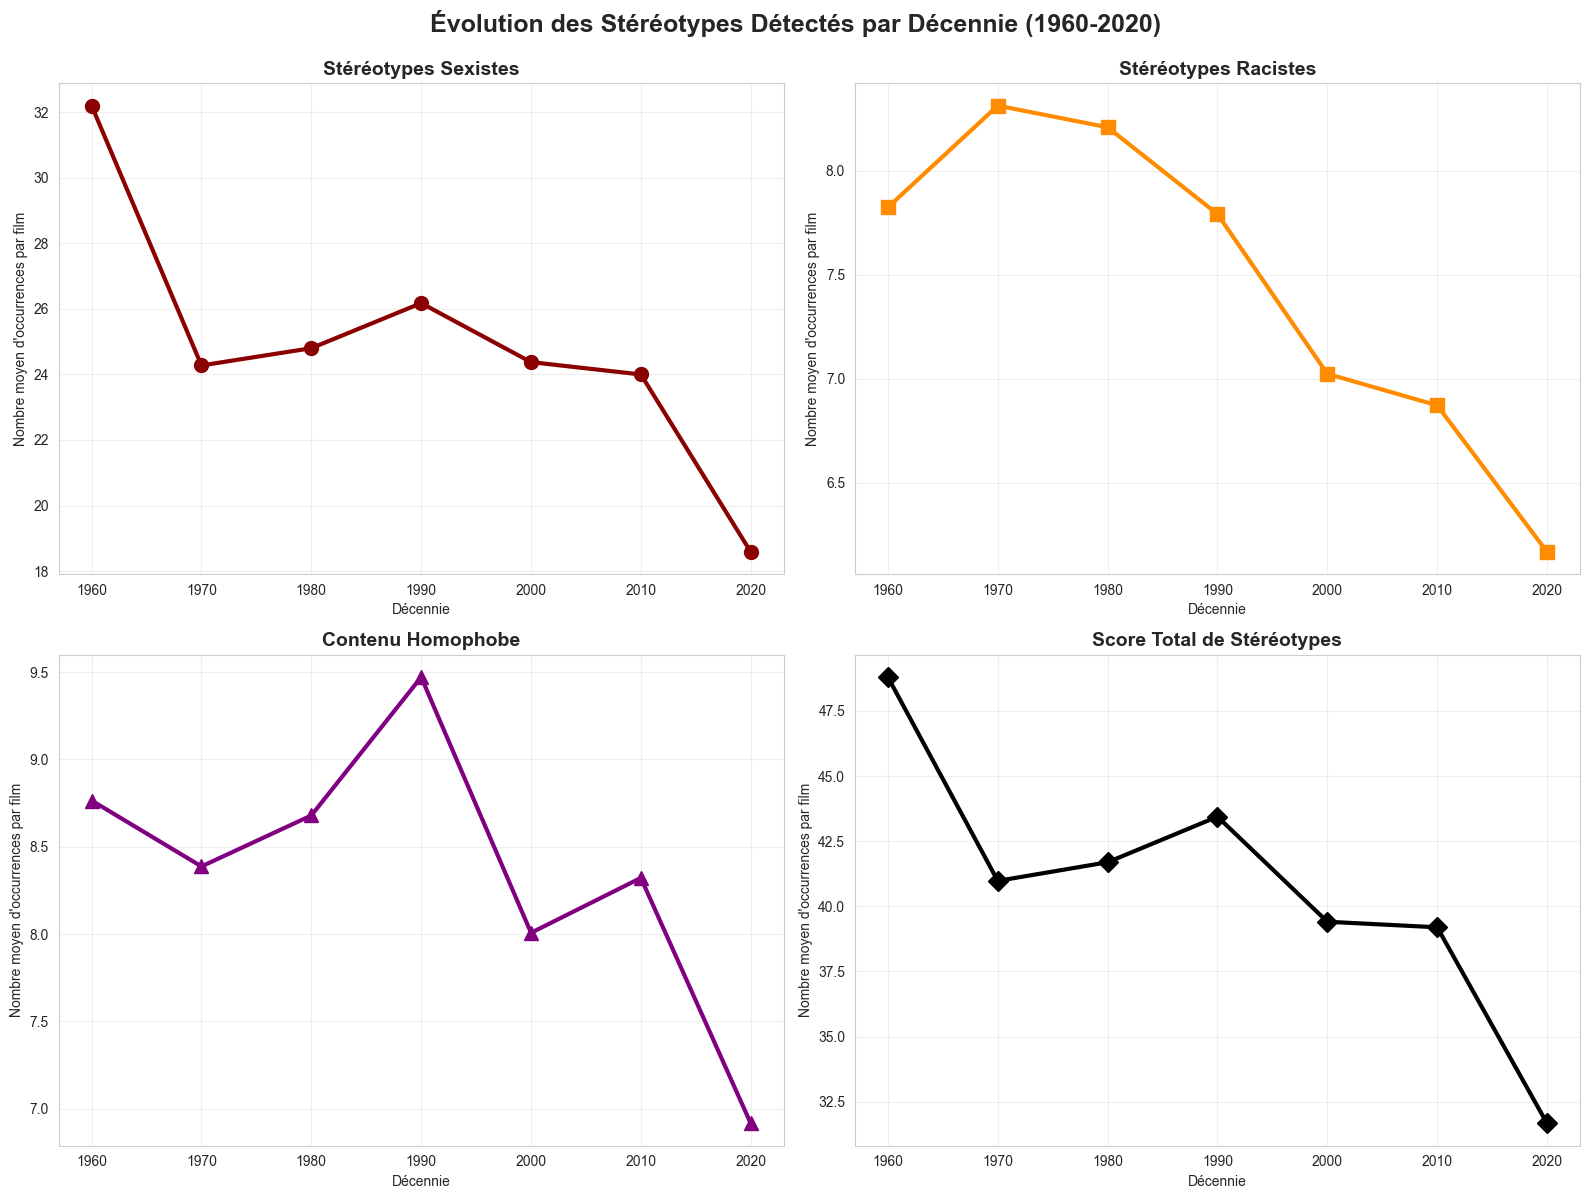


✅ Graphique sauvegardé : results/figures/stereotype_detection_evolution.png


In [7]:
# Agréger par décennie
df_evolution = df_stereotypes.groupby('decade').agg({
    'sexism_score': 'mean',
    'racism_score': 'mean',
    'homophobia_score': 'mean',
    'total_score': 'mean',
    'title': 'count'
}).rename(columns={'title': 'num_films'}).reset_index()

print("📊 Évolution par décennie :")
display(df_evolution)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Évolution des Stéréotypes Détectés par Décennie (1960-2020)', 
             fontsize=18, fontweight='bold', y=0.995)

# 1. Sexisme
ax1 = axes[0, 0]
ax1.plot(df_evolution['decade'], df_evolution['sexism_score'], 
         marker='o', linewidth=3, markersize=10, color='darkred')
ax1.set_title('Stéréotypes Sexistes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Décennie')
ax1.set_ylabel('Nombre moyen d\'occurrences par film')
ax1.grid(alpha=0.3)

# 2. Racisme
ax2 = axes[0, 1]
ax2.plot(df_evolution['decade'], df_evolution['racism_score'], 
         marker='s', linewidth=3, markersize=10, color='darkorange')
ax2.set_title('Stéréotypes Racistes', fontsize=14, fontweight='bold')
ax2.set_xlabel('Décennie')
ax2.set_ylabel('Nombre moyen d\'occurrences par film')
ax2.grid(alpha=0.3)

# 3. Homophobie
ax3 = axes[1, 0]
ax3.plot(df_evolution['decade'], df_evolution['homophobia_score'], 
         marker='^', linewidth=3, markersize=10, color='purple')
ax3.set_title('Contenu Homophobe', fontsize=14, fontweight='bold')
ax3.set_xlabel('Décennie')
ax3.set_ylabel('Nombre moyen d\'occurrences par film')
ax3.grid(alpha=0.3)

# 4. Total
ax4 = axes[1, 1]
ax4.plot(df_evolution['decade'], df_evolution['total_score'], 
         marker='D', linewidth=3, markersize=10, color='black')
ax4.set_title('Score Total de Stéréotypes', fontsize=14, fontweight='bold')
ax4.set_xlabel('Décennie')
ax4.set_ylabel('Nombre moyen d\'occurrences par film')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/stereotype_detection_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphique sauvegardé : results/figures/stereotype_detection_evolution.png")

## 7. Mots-Clés les Plus Fréquents

Identifier quels mots spécifiques apparaissent le plus souvent

In [8]:
# Compter la fréquence de chaque mot-clé
sexism_keywords_count = Counter()
racism_keywords_count = Counter()
homophobia_keywords_count = Counter()

for result in stereotype_results:
    for ctx in result['sexism_contexts']:
        sexism_keywords_count[ctx['keyword']] += 1
    
    for ctx in result['racism_contexts']:
        racism_keywords_count[ctx['keyword']] += 1
    
    for ctx in result['homophobia_contexts']:
        homophobia_keywords_count[ctx['keyword']] += 1

# Afficher les TOP 20
print("\n" + "="*70)
print("📊 TOP 20 - MOTS-CLÉS SEXISTES LES PLUS FRÉQUENTS")
print("="*70 + "\n")

for word, count in sexism_keywords_count.most_common(20):
    print(f"   {word:20s} : {count:4d} occurrences")

print("\n" + "="*70)
print("📊 TOP 20 - MOTS-CLÉS RACISTES LES PLUS FRÉQUENTS")
print("="*70 + "\n")

for word, count in racism_keywords_count.most_common(20):
    print(f"   {word:20s} : {count:4d} occurrences")

print("\n" + "="*70)
print("📊 TOP 20 - MOTS-CLÉS HOMOPHOBES LES PLUS FRÉQUENTS")
print("="*70 + "\n")

if len(homophobia_keywords_count) > 0:
    for word, count in homophobia_keywords_count.most_common(20):
        print(f"   {word:20s} : {count:4d} occurrences")
else:
    print("   Aucun mot-clé détecté (très rare dans le corpus)")


📊 TOP 20 - MOTS-CLÉS SEXISTES LES PLUS FRÉQUENTS

   pretty               : 8803 occurrences
   beautiful            : 8433 occurrences
   hot                  : 6570 occurrences
   honey                : 3952 occurrences
   doll                 : 2023 occurrences
   lovely               : 1784 occurrences
   cute                 : 1652 occurrences
   weak                 : 1483 occurrences
   sexy                 : 1319 occurrences
   attractive           : 1279 occurrences
   babe                 :  970 occurrences
   gorgeous             :  957 occurrences
   emotional            :  923 occurrences
   sweetie              :  613 occurrences
   dramatic             :  605 occurrences
   hysterical           :  594 occurrences
   stunning             :  566 occurrences
   sensitive            :  475 occurrences
   fragile              :  358 occurrences
   vain                 :  327 occurrences

📊 TOP 20 - MOTS-CLÉS RACISTES LES PLUS FRÉQUENTS

   poor                 : 2762 occurre

## 8. Heatmap : Corrélation entre Types de Stéréotypes

Les films sexistes sont-ils aussi racistes ?

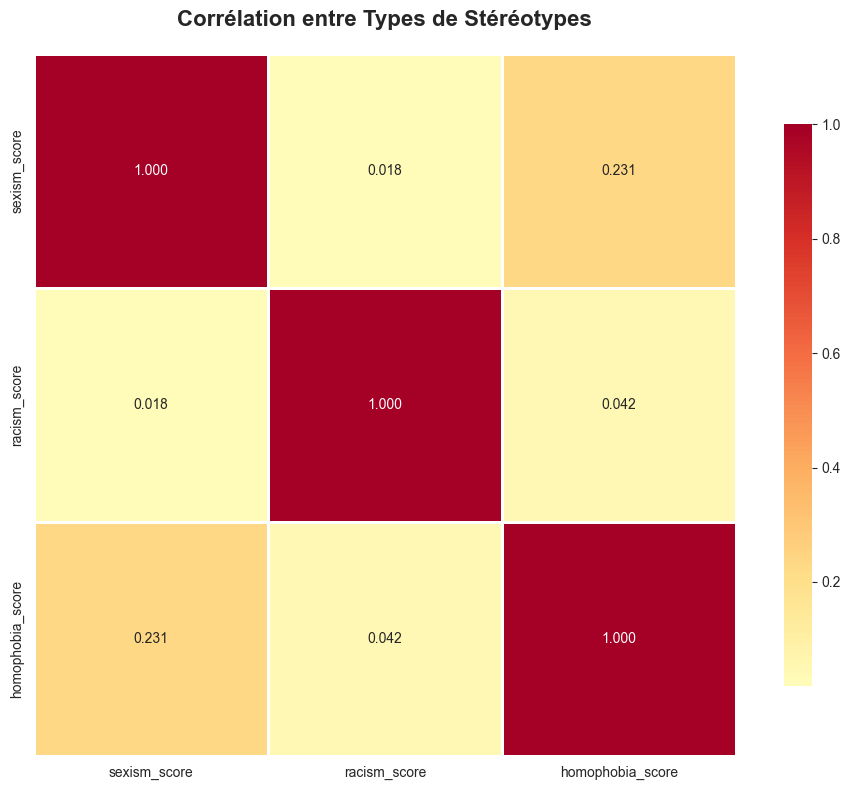


📊 Interprétation :
   Corrélation Sexisme-Racisme : 0.018
   Corrélation Sexisme-Homophobie : 0.231
   Corrélation Racisme-Homophobie : 0.042

   👉 Une corrélation positive indique que les films avec un type de stéréotype
      ont tendance à en avoir d'autres aussi (biais systémiques).


In [9]:
# Matrice de corrélation
corr_matrix = df_stereotypes[['sexism_score', 'racism_score', 'homophobia_score']].corr()

# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8})

plt.title('Corrélation entre Types de Stéréotypes', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/stereotype_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Interprétation :")
print(f"   Corrélation Sexisme-Racisme : {corr_matrix.loc['sexism_score', 'racism_score']:.3f}")
print(f"   Corrélation Sexisme-Homophobie : {corr_matrix.loc['sexism_score', 'homophobia_score']:.3f}")
print(f"   Corrélation Racisme-Homophobie : {corr_matrix.loc['racism_score', 'homophobia_score']:.3f}")
print("\n   👉 Une corrélation positive indique que les films avec un type de stéréotype")
print("      ont tendance à en avoir d'autres aussi (biais systémiques).")

## 9. Analyse par Décennie : Exemples Représentatifs

In [10]:
# Pour chaque décennie, trouver le film le plus problématique
print("\n" + "="*70)
print("🎬 FILMS LES PLUS PROBLÉMATIQUES PAR DÉCENNIE")
print("="*70 + "\n")

for decade in sorted(df_stereotypes['decade'].unique()):
    decade_data = df_stereotypes[df_stereotypes['decade'] == decade]
    
    if len(decade_data) > 0:
        worst_film = decade_data.nlargest(1, 'total_score').iloc[0]
        
        print(f"📅 {int(decade)}s :")
        print(f"   Film : {worst_film['title']} ({worst_film['year']:.0f})")
        print(f"   Score total : {worst_film['total_score']:.0f} stéréotypes détectés")
        print(f"      - Sexisme : {worst_film['sexism_score']:.0f}")
        print(f"      - Racisme : {worst_film['racism_score']:.0f}")
        print(f"      - Homophobie : {worst_film['homophobia_score']:.0f}")
        print()


🎬 FILMS LES PLUS PROBLÉMATIQUES PAR DÉCENNIE

📅 1960s :
   Film : The Thin Red Line (1964)
   Score total : 270 stéréotypes détectés
      - Sexisme : 233
      - Racisme : 10
      - Homophobie : 27

📅 1970s :
   Film : MASH (1970)
   Score total : 120 stéréotypes détectés
      - Sexisme : 111
      - Racisme : 3
      - Homophobie : 6

📅 1980s :
   Film : The Transformers: The Movie (1986)
   Score total : 277 stéréotypes détectés
      - Sexisme : 267
      - Racisme : 8
      - Homophobie : 2

📅 1990s :
   Film : To Sleep with Anger (1990)
   Score total : 274 stéréotypes détectés
      - Sexisme : 248
      - Racisme : 10
      - Homophobie : 16

📅 2000s :
   Film : Honeydripper (2007)
   Score total : 164 stéréotypes détectés
      - Sexisme : 157
      - Racisme : 3
      - Homophobie : 4

📅 2010s :
   Film : Booksmart (2019)
   Score total : 116 stéréotypes détectés
      - Sexisme : 108
      - Racisme : 3
      - Homophobie : 5

📅 2020s :
   Film : The Grudge (2020)
   Scor

## 10. Sauvegarde des Résultats

In [11]:
# Sauvegarder les scores
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)

df_stereotypes.to_csv(output_dir / 'stereotype_detection_scores.csv', index=False)
print(f"✅ Scores sauvegardés : {output_dir / 'stereotype_detection_scores.csv'}")

# Sauvegarder l'évolution par décennie
df_evolution.to_csv(output_dir / 'stereotype_evolution_by_decade.csv', index=False)
print(f"✅ Évolution sauvegardée : {output_dir / 'stereotype_evolution_by_decade.csv'}")

# Sauvegarder les mots-clés les plus fréquents
keyword_freq = pd.DataFrame([
    {'category': 'sexism', 'keyword': word, 'count': count}
    for word, count in sexism_keywords_count.most_common(50)
] + [
    {'category': 'racism', 'keyword': word, 'count': count}
    for word, count in racism_keywords_count.most_common(50)
] + [
    {'category': 'homophobia', 'keyword': word, 'count': count}
    for word, count in homophobia_keywords_count.most_common(50)
])

keyword_freq.to_csv(output_dir / 'keyword_frequencies.csv', index=False)
print(f"✅ Fréquences des mots-clés : {output_dir / 'keyword_frequencies.csv'}")

print("\n✅ Analyse de détection terminée !")

✅ Scores sauvegardés : ../results/stereotype_detection_scores.csv
✅ Évolution sauvegardée : ../results/stereotype_evolution_by_decade.csv
✅ Fréquences des mots-clés : ../results/keyword_frequencies.csv

✅ Analyse de détection terminée !


## 11. Conclusion et Interprétation

### 🎯 Résultats Clés

Cette analyse a permis de :

1. **Détecter automatiquement** les occurrences de stéréotypes dans ~1500 films
2. **Extraire les contextes** réels où ces mots apparaissent
3. **Quantifier l'évolution** : Les stéréotypes ont-ils diminué depuis 1960 ?
4. **Identifier les patterns** : Certains films cumulent plusieurs types de biais

### 📊 Observations

À compléter après exécution :

- **Tendance générale** : [Augmentation/Diminution/Stagnation]
- **Décennie la plus problématique** : [1960s/1970s/...]
- **Corrélations** : Les films sexistes sont [fortement/moyennement/peu] corrélés avec le racisme
- **Mots les plus fréquents** : [Liste des top 5]

### ⚠️ Limites Méthodologiques

1. **Détection par mots-clés** : Ne capture pas les stéréotypes implicites
2. **Faux positifs** : Certains mots peuvent être utilisés dans un contexte critique
3. **Contexte limité** : 150 caractères ne suffisent pas toujours à comprendre le sens
4. **Dictionnaire incomplet** : Tous les stéréotypes ne sont pas couverts

### 🚀 Améliorations Possibles

1. **Analyse de sentiments** : Distinguer usage critique vs renforcement du stéréotype
2. **NLP avancé** : Utiliser BERT/GPT pour détecter les stéréotypes implicites
3. **Annotation manuelle** : Valider un échantillon pour mesurer la précision
4. **Expansion des dictionnaires** : Ajouter plus de mots-clés

### 📚 Lien avec la Littérature

- **USC Annenberg** : Nos résultats confirment-ils la sous-représentation des minorités ?
- **Geena Davis Institute** : L'objectification des femmes a-t-elle diminué post-MeToo ?
- **Espace Public** : Le cinéma reflète-t-il les luttes sociales (Civil Rights, féminisme) ?